In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir.csv')

In [3]:
stir = stir[['TIME', 'Value']].copy()

In [4]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [5]:
stir.index = stir['TIME']

In [6]:
stir = stir[['Value']].copy()

In [7]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [8]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [9]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [10]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [11]:
inf_l = inf_l[:-8]

In [12]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [13]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [14]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%M') + relativedelta(months=i))

In [15]:
infr = pd.DataFrame(inf_l, date_list, ['Value']).iloc[:-4, :]

In [16]:
q_list = []
for y in range(1991, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)

In [17]:
infr['q'] = q_list

In [18]:
g = infr.groupby('q')['Value']
quarters = pd.unique(infr['q']).tolist()

In [19]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [20]:
infr = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [21]:
gdp = pd.read_csv('var_ru/ru_gdp_real.csv')

In [22]:
gdp_l = gdp.T.iloc[1:, 1].tolist()

In [23]:
for i in range(len(gdp_l)):
    gdp_l[i] = str(gdp_l[i])

In [24]:
for i in range(len(gdp_l)):
    gdp_l[i] = gdp_l[i].replace(',', '.')

In [25]:
for i in range(len(gdp_l)):
    gdp_l[i] = float(gdp_l[i])

In [26]:
date_list = []
for i in range(0, len(gdp_l)*3, 3):
    date_list.append(datetime.strptime('1995-01', '%Y-%m') + relativedelta(months=i))

In [27]:
gdp = pd.DataFrame(gdp_l, date_list, ['Value'])

In [28]:
gdp['date'] = gdp.index.tolist()

#### Make full df

In [29]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [30]:
df_var_t = pd.concat([gdp, stir, infr], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                 -1.359580
p-value                         0.601493
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.669773
p-value                   0.016293
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


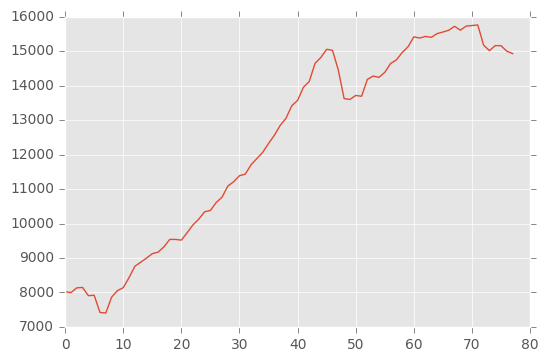

In [31]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.878809
p-value                         0.342095
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (10%)           -2.588072
Critical Value (5%)            -2.901470
dtype: float64


Results of KPSS Test:
Test Statistic            0.375694
p-value                   0.087632
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


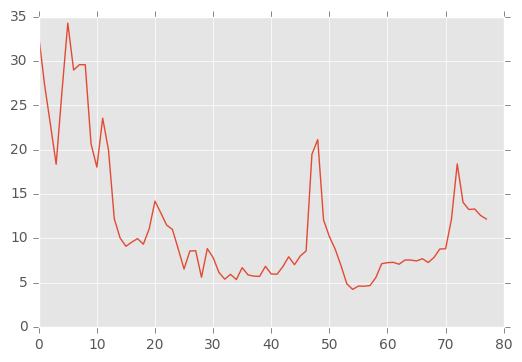

In [32]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.573402
p-value                         0.006290
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (10%)           -2.591103
Critical Value (5%)            -2.907154
dtype: float64


Results of KPSS Test:
Test Statistic            0.412117
p-value                   0.071932
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


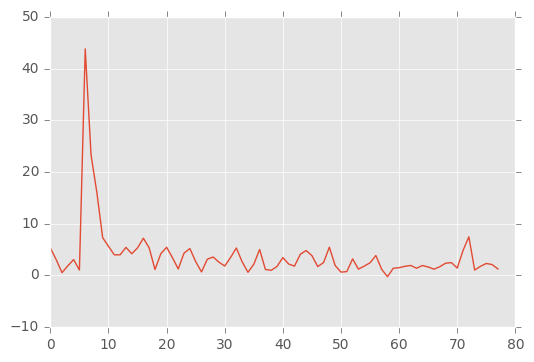

In [33]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                 -5.575741
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (10%)           -2.587498
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.235576
p-value                   0.100000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


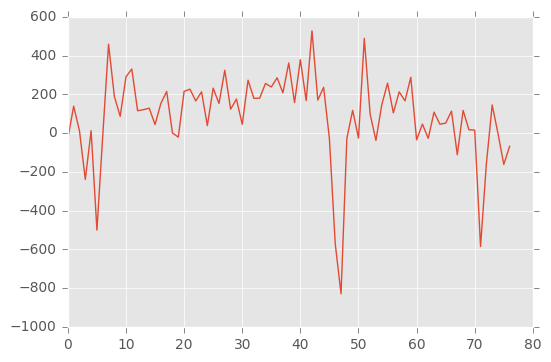

In [34]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -8.596966e+00
p-value                        7.034930e-14
#Lags Used                     1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (10%)          -2.587781e+00
Critical Value (5%)           -2.900925e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.398520
p-value                   0.077793
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
dtype: float64


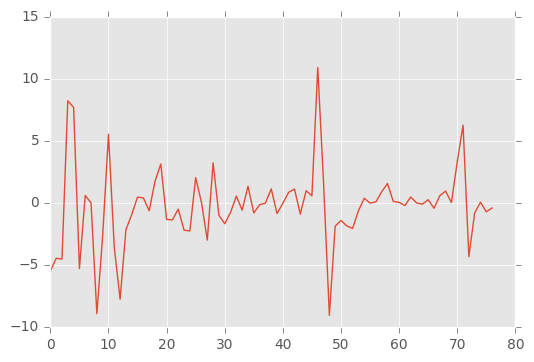

In [35]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -7.011675e+00
p-value                        6.896144e-10
#Lags Used                     2.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (10%)          -2.588072e+00
Critical Value (5%)           -2.901470e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.08435
p-value                   0.10000
#Lags Used               12.00000
Critical Value (10%)      0.34700
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


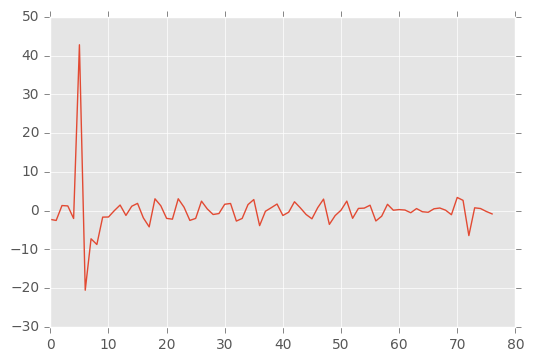

In [36]:
test_stationarity(diff_series(df_var_t['infr']))

In [37]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [38]:
STEPS = 8
LAG = 4

In [39]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [40]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [41]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mae': 2.1470306167064988, 'rmse': 3.1605448188042957, 'mse': 9.9890435516706777}
{'mae': 2.3562900648450329, 'rmse': 3.1494615239980539, 'mse': 9.9191078911441455}
{'mae': 234.64184891325078, 'rmse': 319.24201588318493, 'mse': 101915.4647051597}


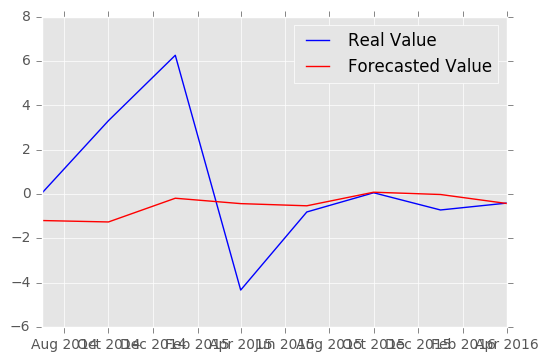

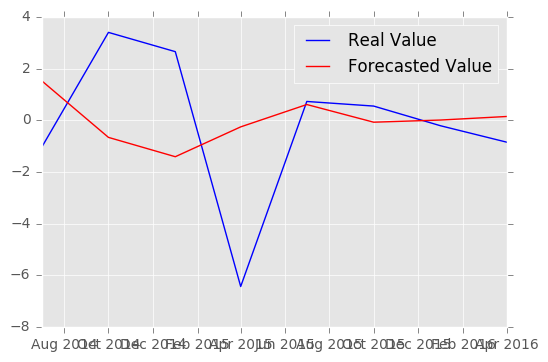

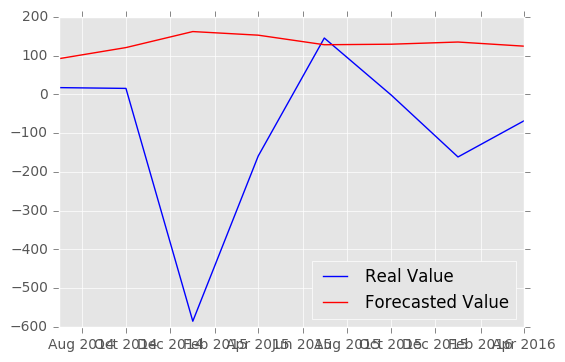

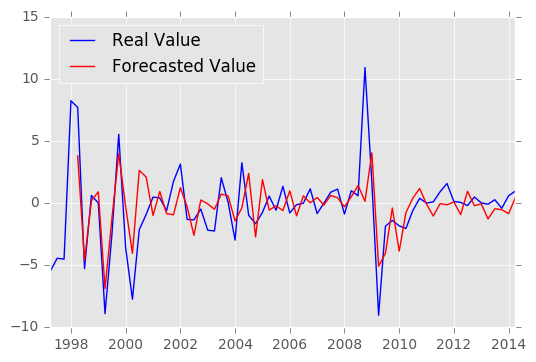

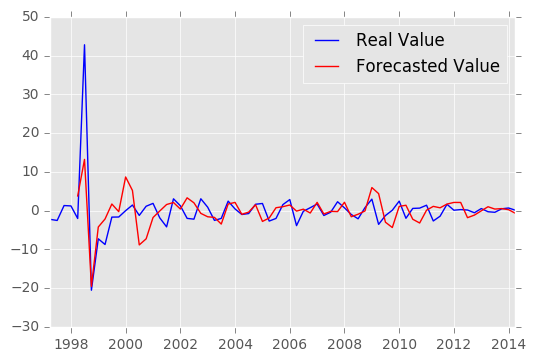

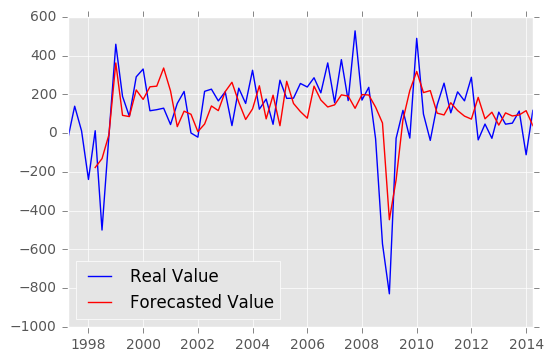

In [42]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mae': 7.3066372426826609, 'rmse': 7.850819745936592, 'mse': 61.635370683187894}
{'mae': 1.5101333630094327, 'rmse': 2.2788204356828716, 'mse': 5.1930225780858734}
{'mae': 1061.3127621886811, 'rmse': 1218.5383861171201, 'mse': 1484835.798440916}


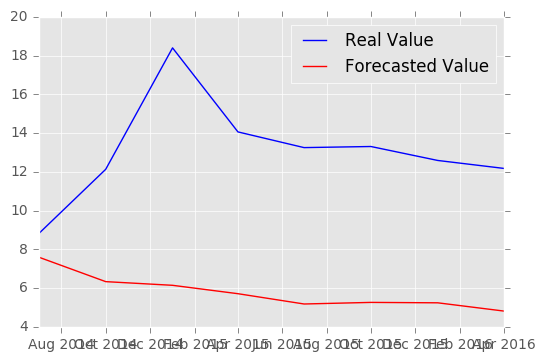

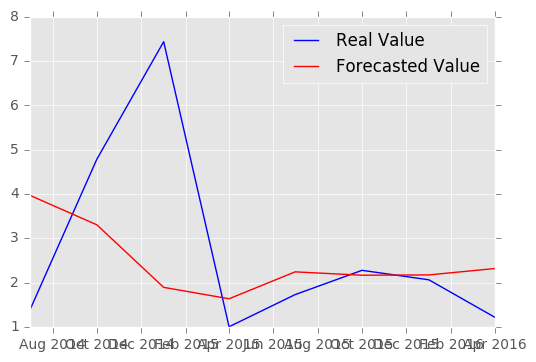

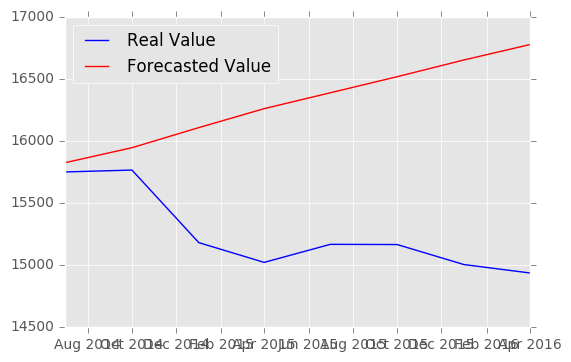

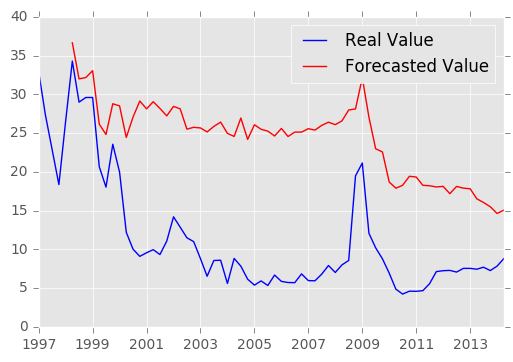

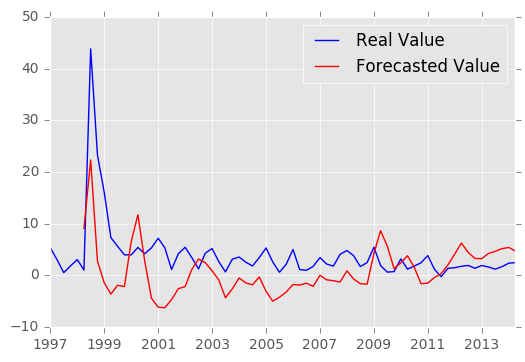

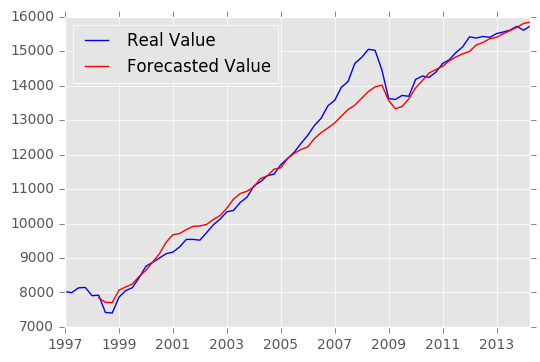

In [43]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [44]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [45]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [46]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.1557
Epoch 2/500
0s - loss: 1.0386
Epoch 3/500
0s - loss: 0.9960
Epoch 4/500
0s - loss: 0.9848
Epoch 5/500
0s - loss: 0.9751
Epoch 6/500
0s - loss: 0.9686
Epoch 7/500
0s - loss: 0.9692
Epoch 8/500
0s - loss: 0.9619
Epoch 9/500
0s - loss: 0.9610
Epoch 10/500
0s - loss: 0.9567
Epoch 11/500
0s - loss: 0.9500
Epoch 12/500
0s - loss: 0.9484
Epoch 13/500
0s - loss: 0.9427
Epoch 14/500
0s - loss: 0.9378
Epoch 15/500
0s - loss: 0.9338
Epoch 16/500
0s - loss: 0.9307
Epoch 17/500
0s - loss: 0.9261
Epoch 18/500
0s - loss: 0.9245
Epoch 19/500
0s - loss: 0.9174
Epoch 20/500
0s - loss: 0.9168
Epoch 21/500
0s - loss: 0.9111
Epoch 22/500
0s - loss: 0.9054
Epoch 23/500
0s - loss: 0.9034
Epoch 24/500
0s - loss: 0.8997
Epoch 25/500
0s - loss: 0.8951
Epoch 26/500
0s - loss: 0.8883
Epoch 27/500
0s - loss: 0.8895
Epoch 28/500
0s - loss: 0.8814
Epoch 29/500
0s - loss: 0.8757
Epoch 30/500
0s - loss: 0.8731
Epoch 31/500
0s - loss: 0.8690
Epoch 32/500
0s - loss: 0.8646
Epoch 33/500
0s -

{'mae': 4.3712166056223882, 'rmse': 5.2328590100824046, 'mse': 27.382813419400605}
{'mae': 3.0800382546975609, 'rmse': 3.8536499091401852, 'mse': 14.850617622216159}
{'mae': 308.03754321663541, 'rmse': 401.33634481367937, 'mse': 161070.86166840454}


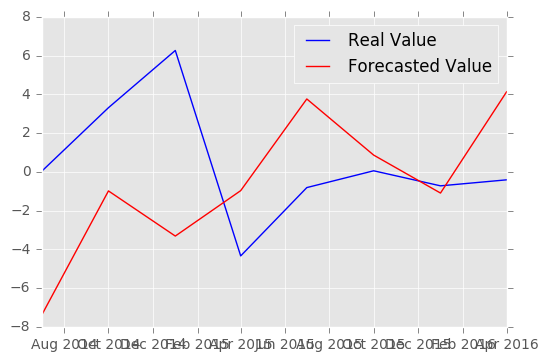

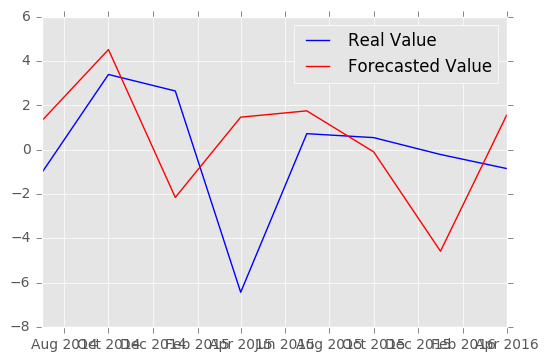

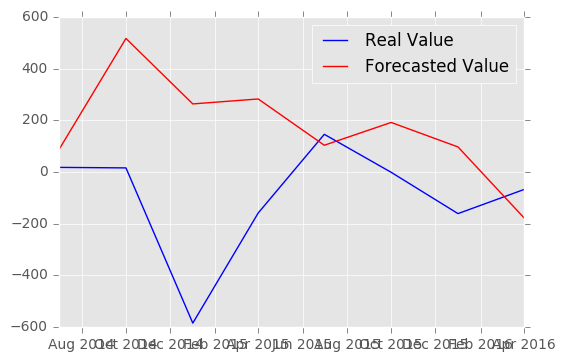

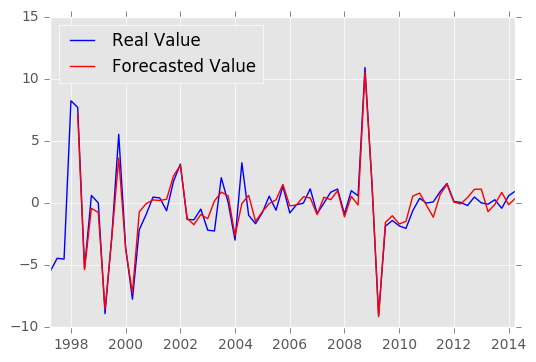

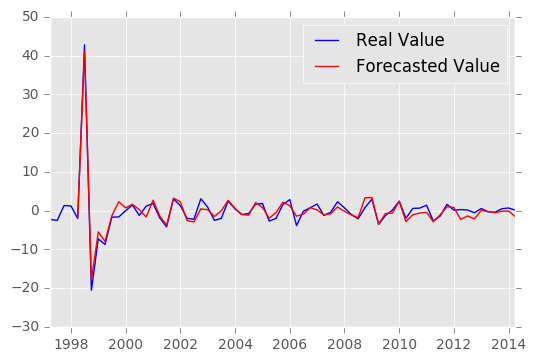

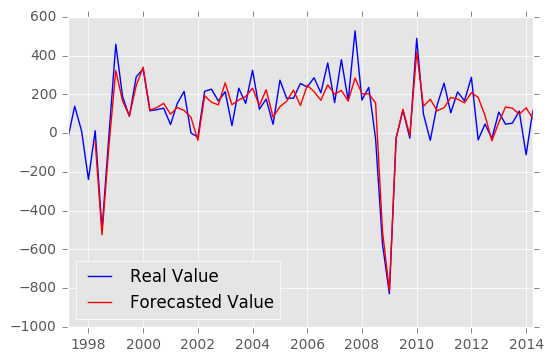

In [48]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 13.197741558756219, 'rmse': 13.877896656117935, 'mse': 192.59601559788933}
{'mae': 4.4873169609426693, 'rmse': 5.0088033520068871, 'mse': 25.088111019075431}
{'mae': 1522.3627488553138, 'rmse': 1694.5597643169874, 'mse': 2871532.7948420439}


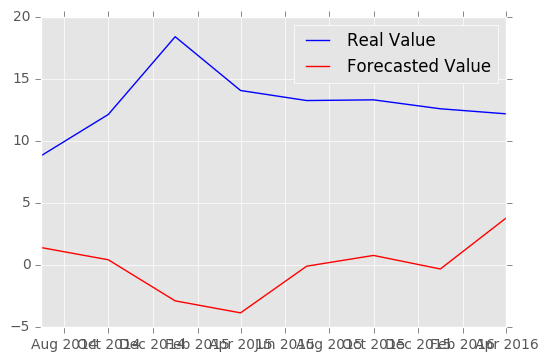

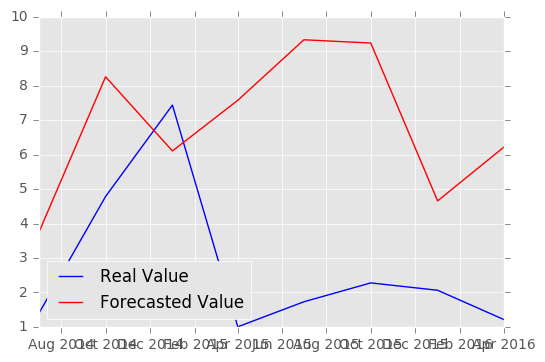

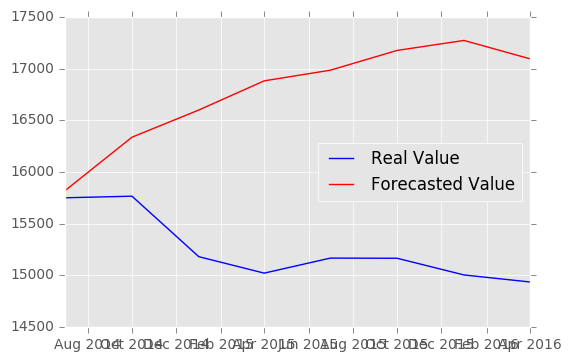

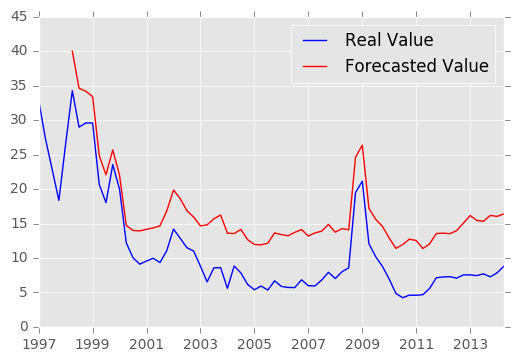

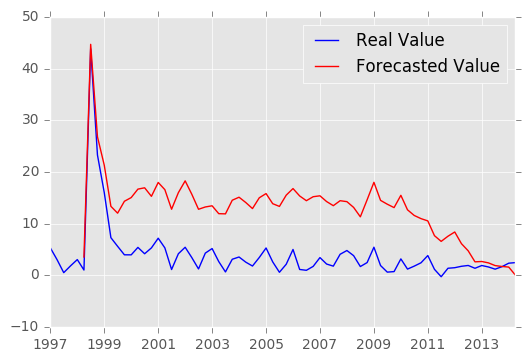

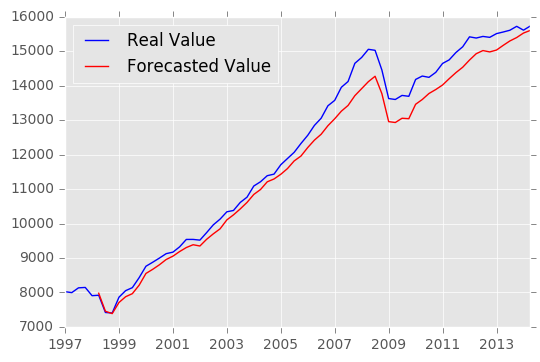

In [49]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [50]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1815
Epoch 2/600
0s - loss: 1.0579
Epoch 3/600
0s - loss: 1.0101
Epoch 4/600
0s - loss: 0.9958
Epoch 5/600
0s - loss: 0.9860
Epoch 6/600
0s - loss: 0.9804
Epoch 7/600
0s - loss: 0.9735
Epoch 8/600
0s - loss: 0.9689
Epoch 9/600
0s - loss: 0.9670
Epoch 10/600
0s - loss: 0.9646
Epoch 11/600
0s - loss: 0.9596
Epoch 12/600
0s - loss: 0.9552
Epoch 13/600
0s - loss: 0.9508
Epoch 14/600
0s - loss: 0.9498
Epoch 15/600
0s - loss: 0.9426
Epoch 16/600
0s - loss: 0.9412
Epoch 17/600
0s - loss: 0.9366
Epoch 18/600
0s - loss: 0.9340
Epoch 19/600
0s - loss: 0.9277
Epoch 20/600
0s - loss: 0.9260
Epoch 21/600
0s - loss: 0.9224
Epoch 22/600
0s - loss: 0.9190
Epoch 23/600
0s - loss: 0.9134
Epoch 24/600
0s - loss: 0.9094
Epoch 25/600
0s - loss: 0.9069
Epoch 26/600
0s - loss: 0.9044
Epoch 27/600
0s - loss: 0.8999
Epoch 28/600
0s - loss: 0.8955
Epoch 29/600
0s - loss: 0.8923
Epoch 30/600
0s - loss: 0.8881
Epoch 31/600
0s - loss: 0.8867
Epoch 32/600
0s - loss: 0.8806
Epoch 33/600
0s -

{'mae': 6.0527759974087338, 'rmse': 6.878509552278973, 'mse': 47.313893660793077}
{'mae': 3.9277493205757033, 'rmse': 4.4882620267549598, 'mse': 20.144496020810536}
{'mae': 473.28334233159217, 'rmse': 580.032019400595, 'mse': 336437.14352993225}


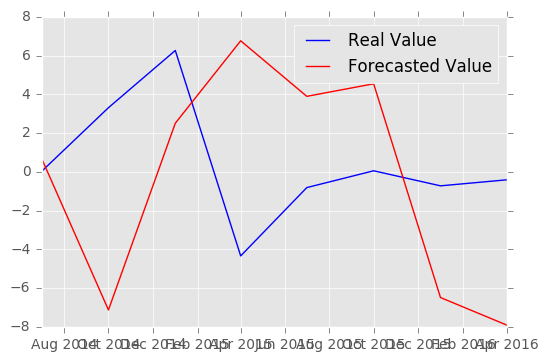

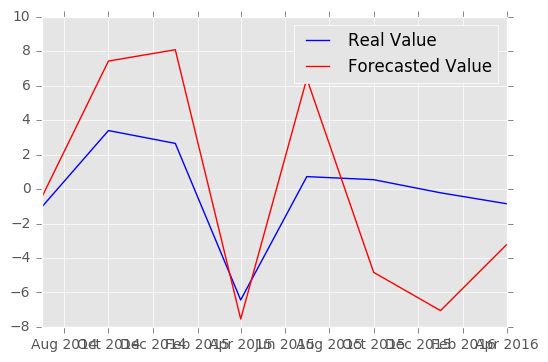

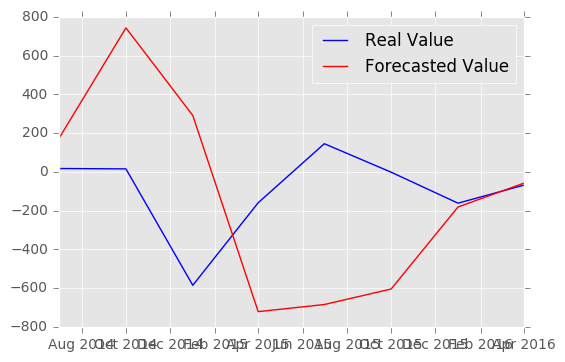

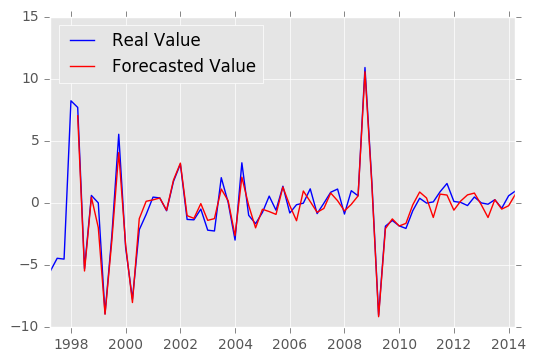

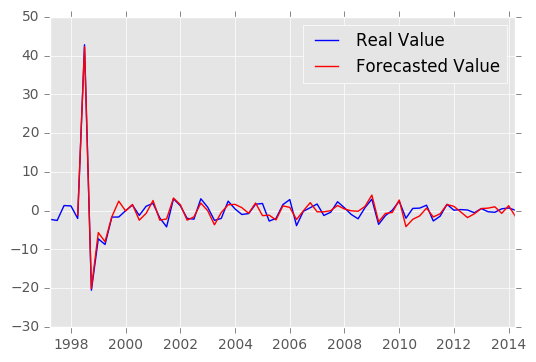

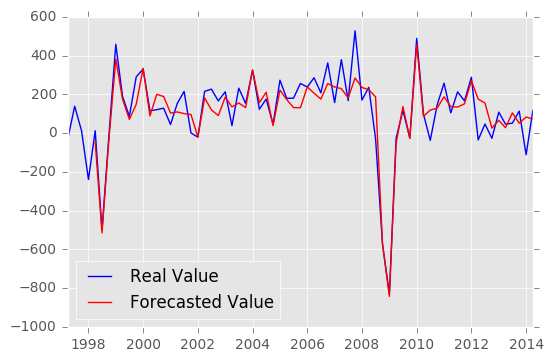

In [51]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 5.3678219838266621, 'rmse': 6.8823741346692584, 'mse': 47.367073729564424}
{'mae': 6.297497218974403, 'rmse': 7.9563833334004466, 'mse': 63.304035748012403}
{'mae': 637.69614172465049, 'rmse': 841.21108292378574, 'mse': 707636.0860338083}


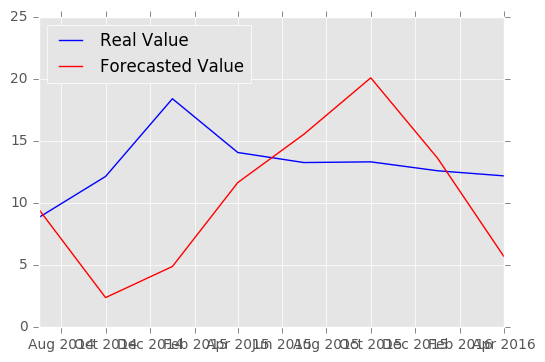

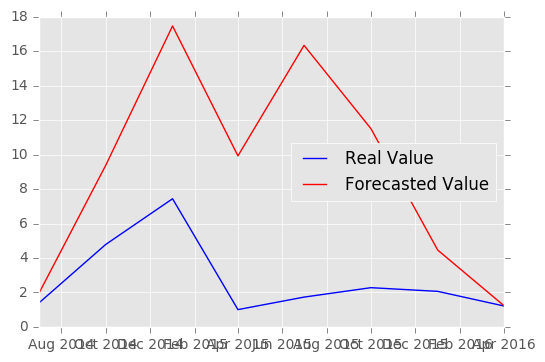

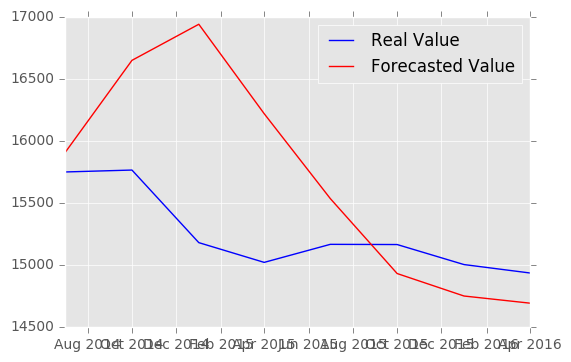

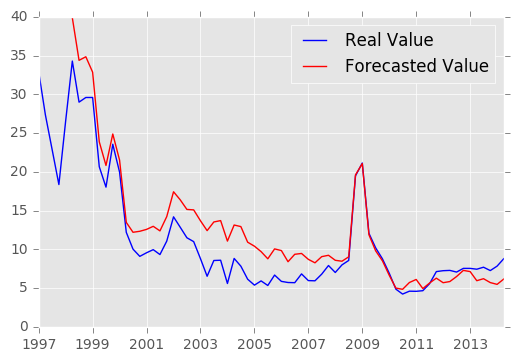

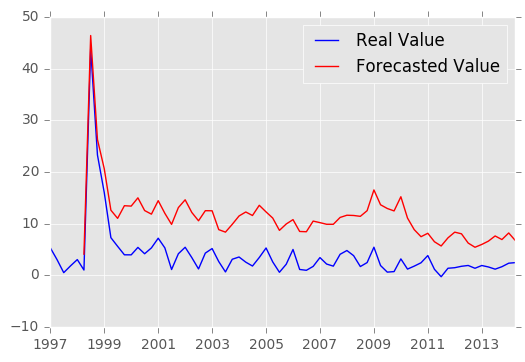

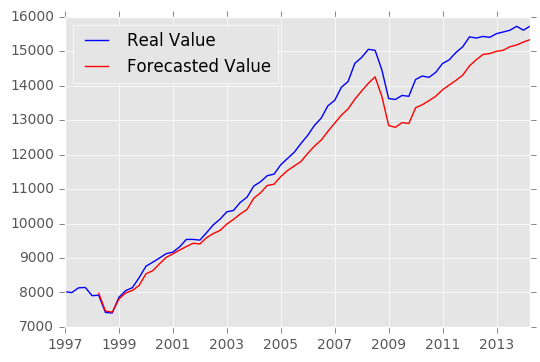

In [52]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.1142
Epoch 2/600
0s - loss: 1.0462
Epoch 3/600
0s - loss: 1.0364
Epoch 4/600
0s - loss: 1.0014
Epoch 5/600
0s - loss: 1.0076
Epoch 6/600
0s - loss: 0.9843
Epoch 7/600
0s - loss: 1.0073
Epoch 8/600
0s - loss: 1.0009
Epoch 9/600
0s - loss: 1.0092
Epoch 10/600
0s - loss: 0.9953
Epoch 11/600
0s - loss: 1.0284
Epoch 12/600
0s - loss: 0.9823
Epoch 13/600
0s - loss: 0.9914
Epoch 14/600
0s - loss: 0.9916
Epoch 15/600
0s - loss: 0.9917
Epoch 16/600
0s - loss: 0.9881
Epoch 17/600
0s - loss: 0.9948
Epoch 18/600
0s - loss: 1.0047
Epoch 19/600
0s - loss: 0.9904
Epoch 20/600
0s - loss: 0.9901
Epoch 21/600
0s - loss: 0.9924
Epoch 22/600
0s - loss: 0.9969
Epoch 23/600
0s - loss: 0.9891
Epoch 24/600
0s - loss: 0.9829
Epoch 25/600
0s - loss: 0.9920
Epoch 26/600
0s - loss: 0.9836
Epoch 27/600
0s - loss: 0.9802
Epoch 28/600
0s - loss: 0.9961
Epoch 29/600
0s - loss: 0.9844
Epoch 30/600
0s - loss: 0.9942
Epoch 31/600
0s - loss: 0.9758
Epoch 32/600
0s - loss: 0.9802
Epoch 33/600
0s -

{'mae': 5.6439088537959776, 'rmse': 6.7835528767989706, 'mse': 46.016589632327594}
{'mae': 5.0155166704694931, 'rmse': 7.1186580037340157, 'mse': 50.675291774126364}
{'mae': 348.35846299900913, 'rmse': 413.75386323113338, 'mse': 171192.25933868744}


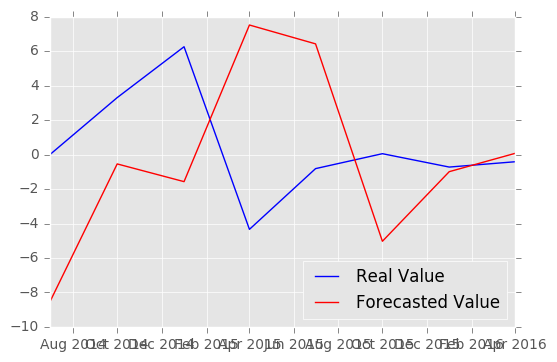

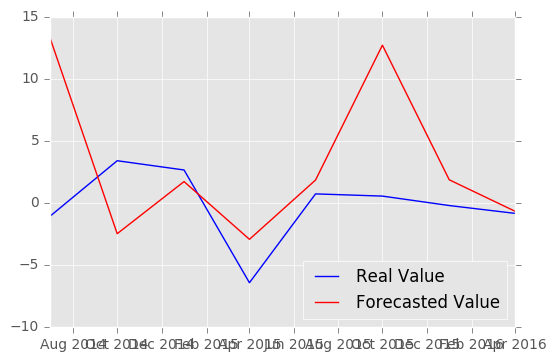

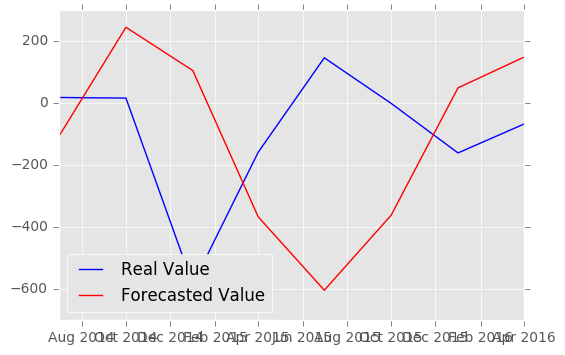

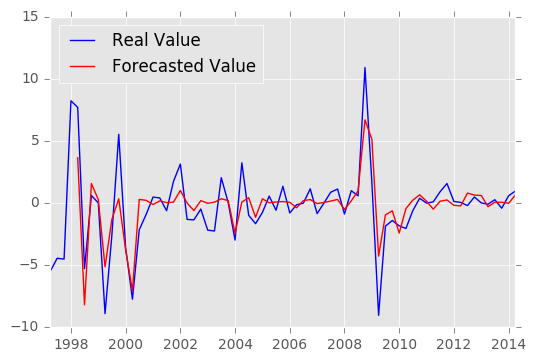

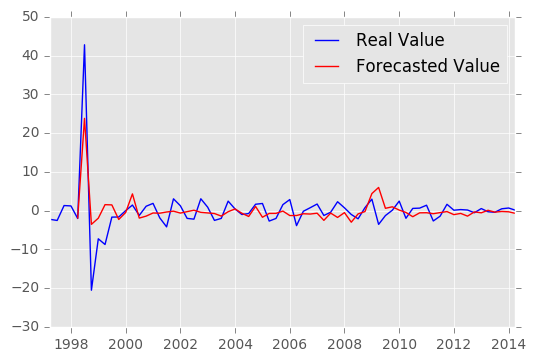

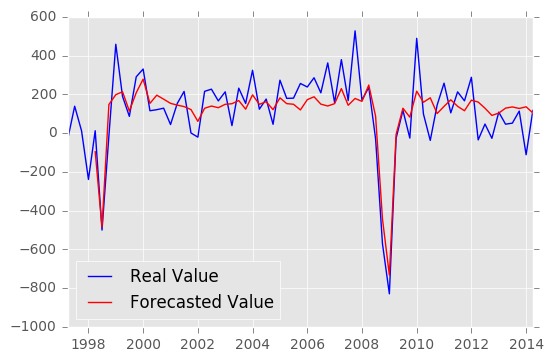

In [54]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 8.6353655119254924, 'rmse': 10.119858722799069, 'mse': 102.41154056941242}
{'mae': 16.280065503333599, 'rmse': 17.953613113281815, 'mse': 322.33222382140468}
{'mae': 338.88319038915597, 'rmse': 419.97911319268542, 'mse': 176382.45551811447}


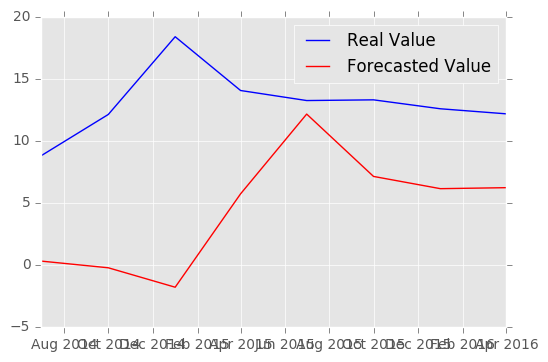

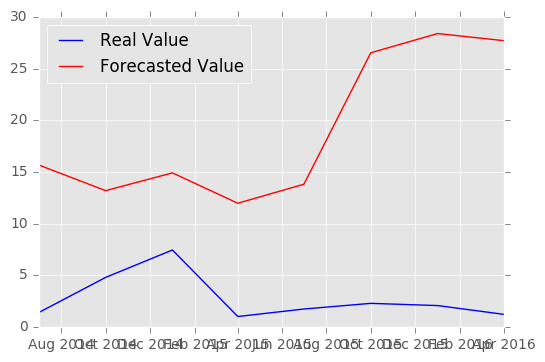

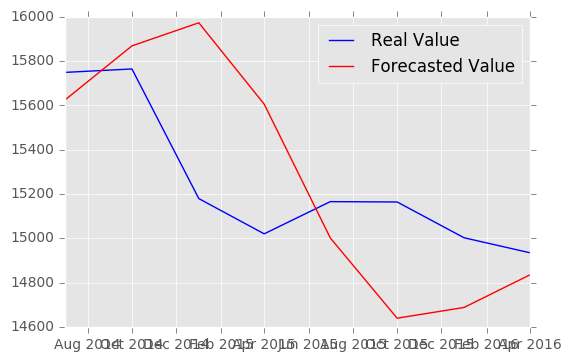

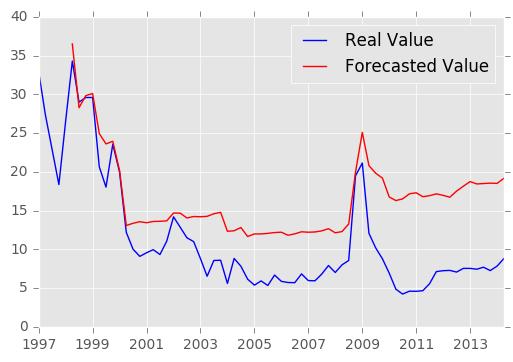

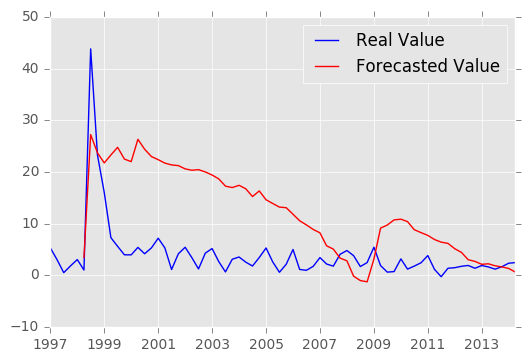

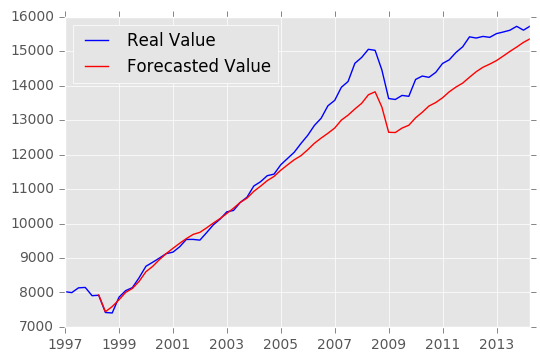

In [55]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [56]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [57]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.4896
Epoch 2/600
0s - loss: 1.2132
Epoch 3/600
0s - loss: 1.0919
Epoch 4/600
0s - loss: 1.0190
Epoch 5/600
0s - loss: 0.9671
Epoch 6/600
0s - loss: 0.9201
Epoch 7/600
0s - loss: 0.8737
Epoch 8/600
0s - loss: 0.8334
Epoch 9/600
0s - loss: 0.7890
Epoch 10/600
0s - loss: 0.7448
Epoch 11/600
0s - loss: 0.6983
Epoch 12/600
0s - loss: 0.6577
Epoch 13/600
0s - loss: 0.6245
Epoch 14/600
0s - loss: 0.5895
Epoch 15/600
0s - loss: 0.5614
Epoch 16/600
0s - loss: 0.5384
Epoch 17/600
0s - loss: 0.5197
Epoch 18/600
0s - loss: 0.5052
Epoch 19/600
0s - loss: 0.4943
Epoch 20/600
0s - loss: 0.4878
Epoch 21/600
0s - loss: 0.4768
Epoch 22/600
0s - loss: 0.4713
Epoch 23/600
0s - loss: 0.4682
Epoch 24/600
0s - loss: 0.4615
Epoch 25/600
0s - loss: 0.4563
Epoch 26/600
0s - loss: 0.4502
Epoch 27/600
0s - loss: 0.4462
Epoch 28/600
0s - loss: 0.4402
Epoch 29/600
0s - loss: 0.4340
Epoch 30/600
0s - loss: 0.4288
Epoch 31/600
0s - loss: 0.4260
Epoch 32/600
0s - loss: 0.4196
Epoch 33/600
0s -

{'mae': 4.7400183907912616, 'rmse': 6.8978930809438541, 'mse': 47.580928956133093}
{'mae': 2.9736737112360334, 'rmse': 4.4315342728467897, 'mse': 19.638496011415722}
{'mae': 2416.125777493754, 'rmse': 3020.0907712500443, 'mse': 9120948.2665896881}


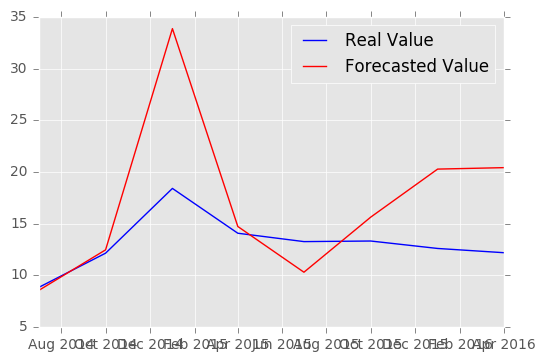

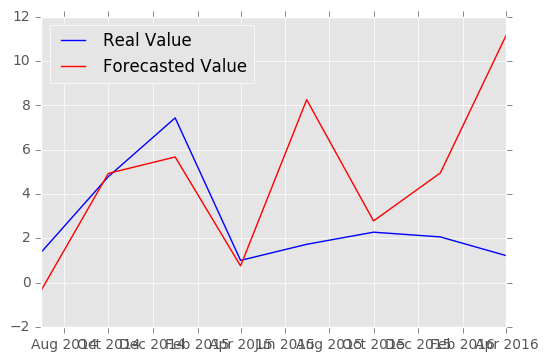

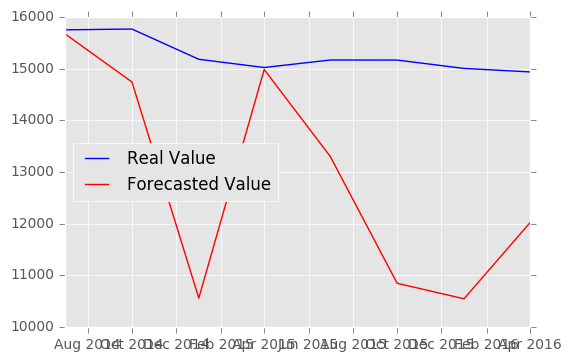

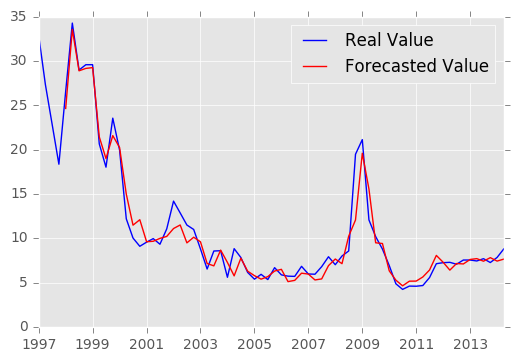

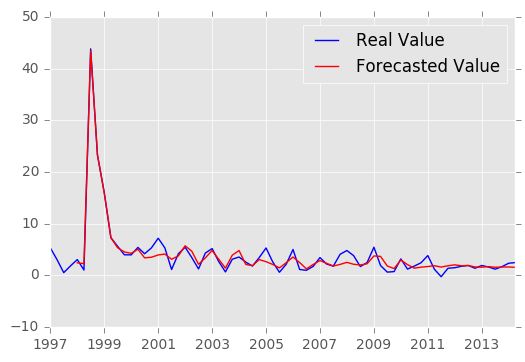

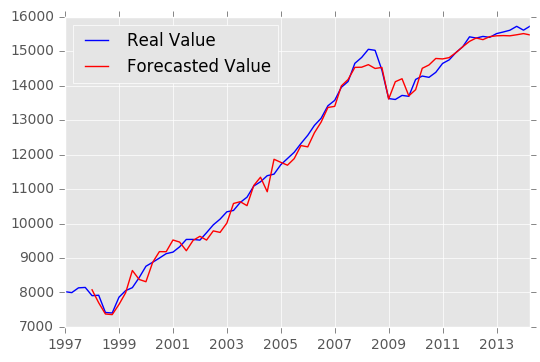

In [58]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0455
Epoch 2/600
0s - loss: 0.9868
Epoch 3/600
0s - loss: 0.9357
Epoch 4/600
0s - loss: 0.8894
Epoch 5/600
0s - loss: 0.8438
Epoch 6/600
0s - loss: 0.8021
Epoch 7/600
0s - loss: 0.7601
Epoch 8/600
0s - loss: 0.7145
Epoch 9/600
0s - loss: 0.6723
Epoch 10/600
0s - loss: 0.6337
Epoch 11/600
0s - loss: 0.5960
Epoch 12/600
0s - loss: 0.5664
Epoch 13/600
0s - loss: 0.5399
Epoch 14/600
0s - loss: 0.5169
Epoch 15/600
0s - loss: 0.5008
Epoch 16/600
0s - loss: 0.4862
Epoch 17/600
0s - loss: 0.4716
Epoch 18/600
0s - loss: 0.4616
Epoch 19/600
0s - loss: 0.4511
Epoch 20/600
0s - loss: 0.4413
Epoch 21/600
0s - loss: 0.4347
Epoch 22/600
0s - loss: 0.4254
Epoch 23/600
0s - loss: 0.4207
Epoch 24/600
0s - loss: 0.4102
Epoch 25/600
0s - loss: 0.4055
Epoch 26/600
0s - loss: 0.3964
Epoch 27/600
0s - loss: 0.3905
Epoch 28/600
0s - loss: 0.3832
Epoch 29/600
0s - loss: 0.3776
Epoch 30/600
0s - loss: 0.3715
Epoch 31/600
0s - loss: 0.3668
Epoch 32/600
0s - loss: 0.3607
Epoch 33/600
0s -

{'mae': 8.8898538207574838, 'rmse': 10.023951975133489, 'mse': 100.47961319978256}
{'mae': 3.2846123622300079, 'rmse': 5.3272489787497275, 'mse': 28.379581681590018}
{'mae': 3347.1702906208538, 'rmse': 3781.6806055728102, 'mse': 14301108.202565536}


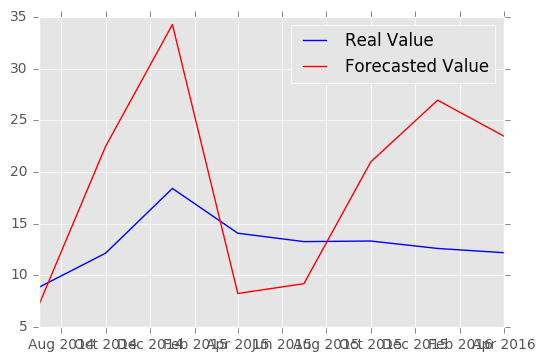

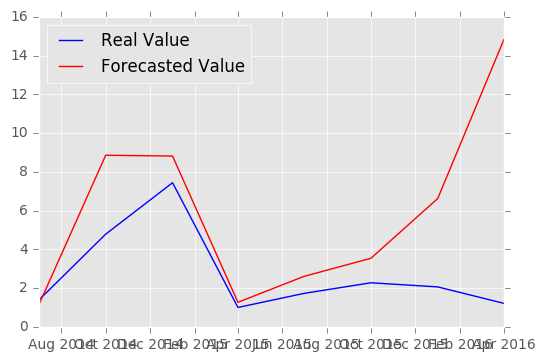

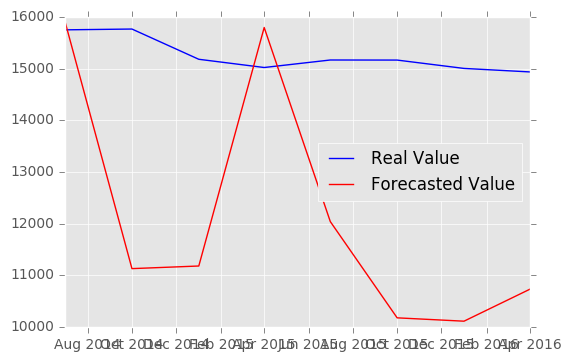

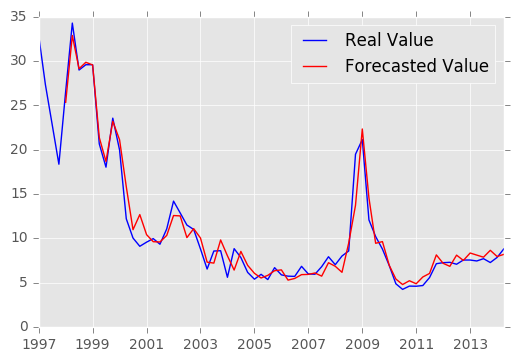

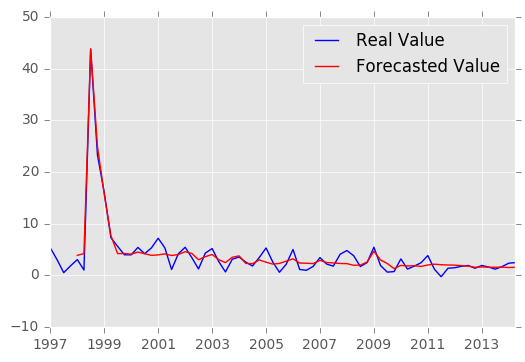

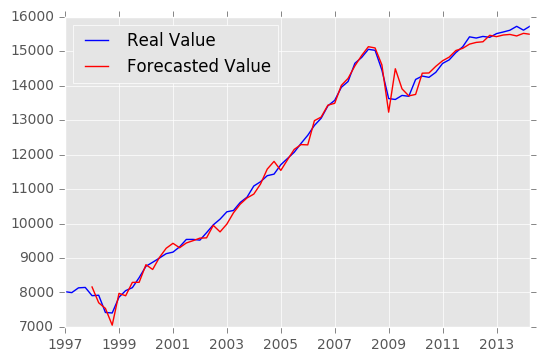

In [60]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [61]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.3631
Epoch 2/600
0s - loss: 1.1099
Epoch 3/600
0s - loss: 0.9958
Epoch 4/600
0s - loss: 0.9250
Epoch 5/600
0s - loss: 0.8721
Epoch 6/600
0s - loss: 0.8265
Epoch 7/600
0s - loss: 0.7889
Epoch 8/600
0s - loss: 0.7462
Epoch 9/600
0s - loss: 0.7062
Epoch 10/600
0s - loss: 0.6674
Epoch 11/600
0s - loss: 0.6329
Epoch 12/600
0s - loss: 0.5994
Epoch 13/600
0s - loss: 0.5693
Epoch 14/600
0s - loss: 0.5450
Epoch 15/600
0s - loss: 0.5238
Epoch 16/600
0s - loss: 0.5036
Epoch 17/600
0s - loss: 0.4874
Epoch 18/600
0s - loss: 0.4726
Epoch 19/600
0s - loss: 0.4620
Epoch 20/600
0s - loss: 0.4488
Epoch 21/600
0s - loss: 0.4388
Epoch 22/600
0s - loss: 0.4317
Epoch 23/600
0s - loss: 0.4243
Epoch 24/600
0s - loss: 0.4134
Epoch 25/600
0s - loss: 0.4056
Epoch 26/600
0s - loss: 0.4000
Epoch 27/600
0s - loss: 0.3931
Epoch 28/600
0s - loss: 0.3880
Epoch 29/600
0s - loss: 0.3807
Epoch 30/600
0s - loss: 0.3769
Epoch 31/600
0s - loss: 0.3693
Epoch 32/600
0s - loss: 0.3637
Epoch 33/600
0s -

{'mae': 10.049316632272506, 'rmse': 12.211078147023807, 'mse': 149.11042951272239}
{'mae': 3.1174974836394291, 'rmse': 4.8856214980358752, 'mse': 23.869297422070307}
{'mae': 2922.1543916416003, 'rmse': 3517.314682703261, 'mse': 12371502.577159941}


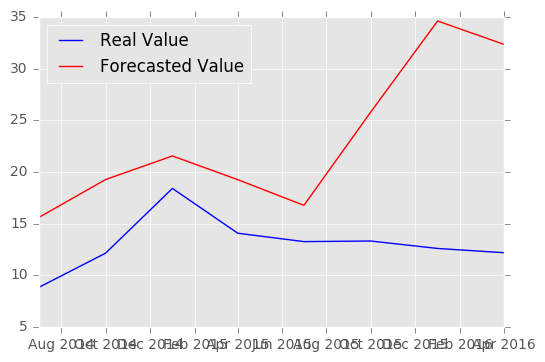

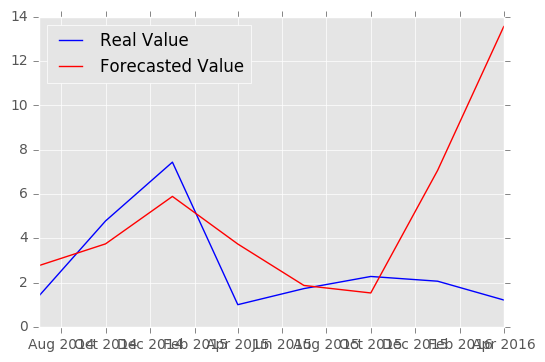

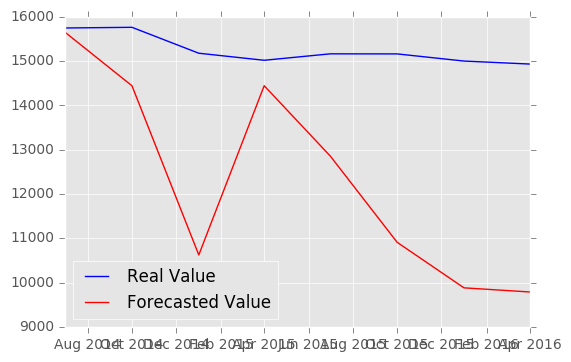

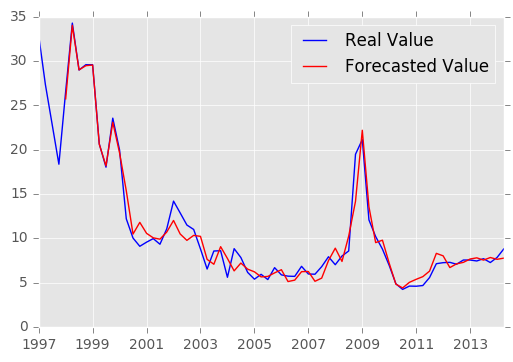

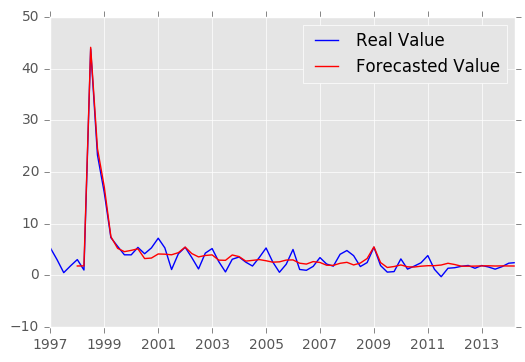

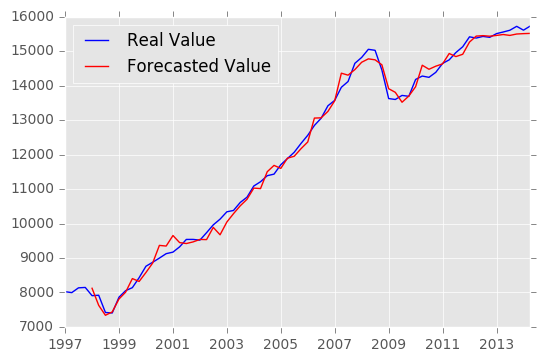

In [62]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [63]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [65]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 0.9829
Epoch 2/200
0s - loss: 0.9688
Epoch 3/200
0s - loss: 0.9621
Epoch 4/200
0s - loss: 0.9600
Epoch 5/200
0s - loss: 0.9529
Epoch 6/200
0s - loss: 0.9512
Epoch 7/200
0s - loss: 0.9475
Epoch 8/200
0s - loss: 0.9425
Epoch 9/200
0s - loss: 0.9391
Epoch 10/200
0s - loss: 0.9360
Epoch 11/200
0s - loss: 0.9329
Epoch 12/200
0s - loss: 0.9263
Epoch 13/200
0s - loss: 0.9272
Epoch 14/200
0s - loss: 0.9186
Epoch 15/200
0s - loss: 0.9125
Epoch 16/200
0s - loss: 0.9104
Epoch 17/200
0s - loss: 0.9044
Epoch 18/200
0s - loss: 0.9010
Epoch 19/200
0s - loss: 0.8966
Epoch 20/200
0s - loss: 0.8908
Epoch 21/200
0s - loss: 0.8892
Epoch 22/200
0s - loss: 0.8805
Epoch 23/200
0s - loss: 0.8754
Epoch 24/200
0s - loss: 0.8700
Epoch 25/200
0s - loss: 0.8676
Epoch 26/200
0s - loss: 0.8628
Epoch 27/200
0s - loss: 0.8569
Epoch 28/200
0s - loss: 0.8540
Epoch 29/200
0s - loss: 0.8469
Epoch 30/200
0s - loss: 0.8407
Epoch 31/200
0s - loss: 0.8361
Epoch 32/200
0s - loss: 0.8326
Epoch 33/200
0s -

{'mae': 2.6551501957588624, 'rmse': 3.509465251209257, 'mse': 12.316346349445254}
{'mae': 3.8753961617507691, 'rmse': 4.3978558855540211, 'mse': 19.34113639010214}
{'mae': 249.36768545599375, 'rmse': 316.94663339676282, 'mse': 100455.16842154195}


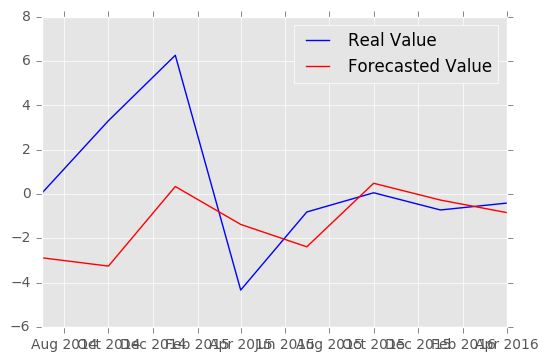

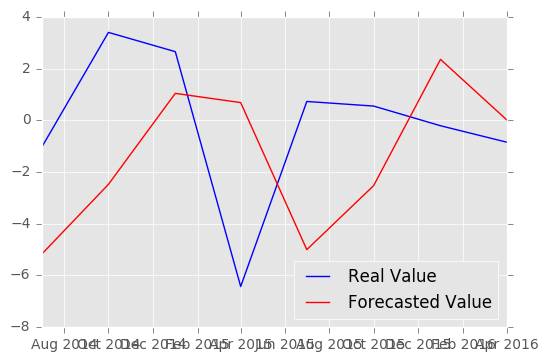

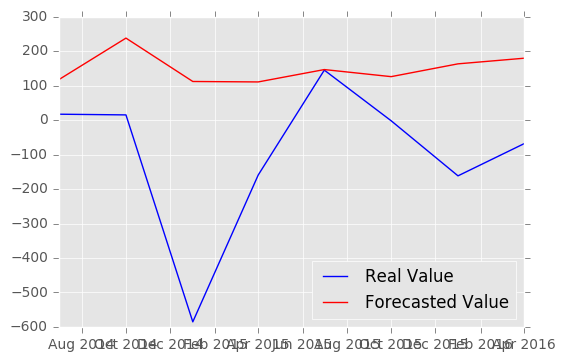

In [66]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 11.810389229022821, 'rmse': 12.382900504262091, 'mse': 153.33622489845433}
{'mae': 9.3172946417969911, 'rmse': 9.808483130227561, 'mse': 96.206341315958667}
{'mae': 1149.4301202121155, 'rmse': 1301.641436951126, 'mse': 1694270.4303881922}


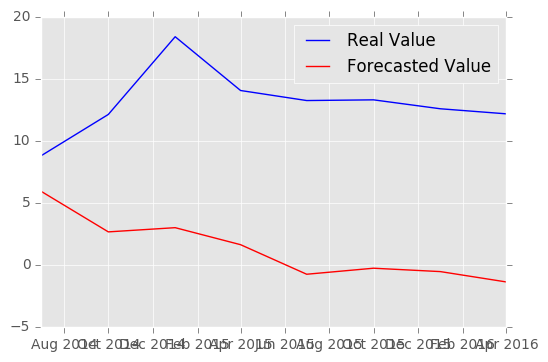

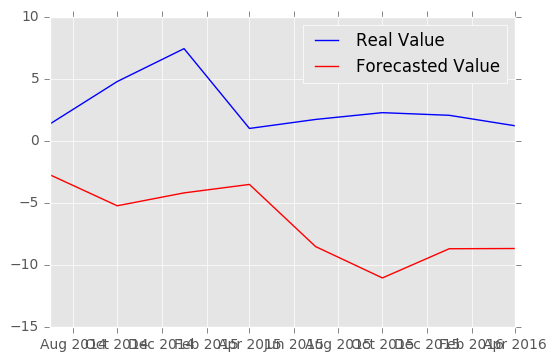

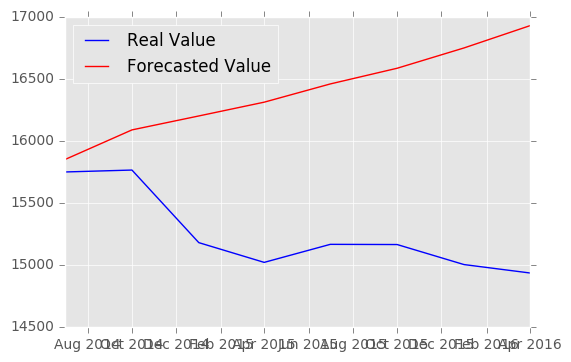

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2505
Epoch 2/200
0s - loss: 1.0766
Epoch 3/200
0s - loss: 1.0196
Epoch 4/200
0s - loss: 0.9957
Epoch 5/200
0s - loss: 0.9833
Epoch 6/200
0s - loss: 0.9792
Epoch 7/200
0s - loss: 0.9742
Epoch 8/200
0s - loss: 0.9713
Epoch 9/200
0s - loss: 0.9666
Epoch 10/200
0s - loss: 0.9652
Epoch 11/200
0s - loss: 0.9646
Epoch 12/200
0s - loss: 0.9599
Epoch 13/200
0s - loss: 0.9563
Epoch 14/200
0s - loss: 0.9515
Epoch 15/200
0s - loss: 0.9488
Epoch 16/200
0s - loss: 0.9456
Epoch 17/200
0s - loss: 0.9433
Epoch 18/200
0s - loss: 0.9390
Epoch 19/200
0s - loss: 0.9362
Epoch 20/200
0s - loss: 0.9278
Epoch 21/200
0s - loss: 0.9260
Epoch 22/200
0s - loss: 0.9210
Epoch 23/200
0s - loss: 0.9153
Epoch 24/200
0s - loss: 0.9120
Epoch 25/200
0s - loss: 0.9056
Epoch 26/200
0s - loss: 0.9031
Epoch 27/200
0s - loss: 0.8974
Epoch 28/200
0s - loss: 0.8924
Epoch 29/200
0s - loss: 0.8918
Epoch 30/200
0s - loss: 0.8852
Epoch 31/200
0s - loss: 0.8774
Epoch 32/200
0s - loss: 0.8718
Epoch 33/200
0s -

{'mae': 2.7432700278419873, 'rmse': 3.7513576146258778, 'mse': 14.072683952811555}
{'mae': 3.8040590080194105, 'rmse': 4.5974360063705833, 'mse': 21.136417832672699}
{'mae': 242.53457371644592, 'rmse': 312.66502060766624, 'mse': 97759.41511159236}


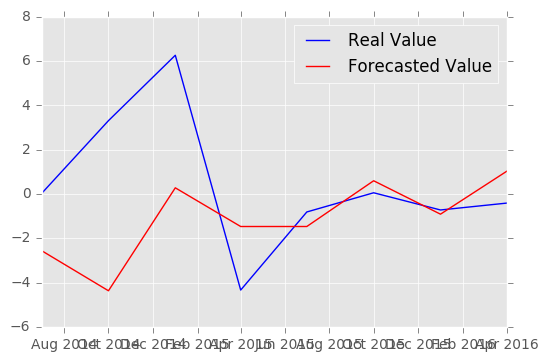

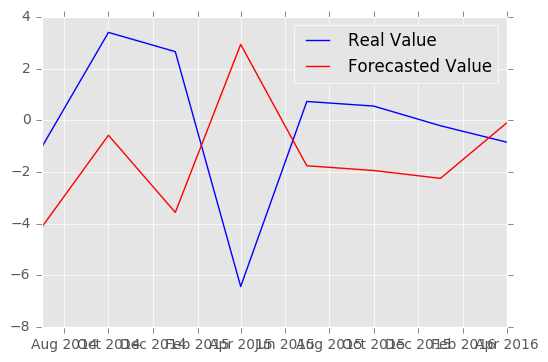

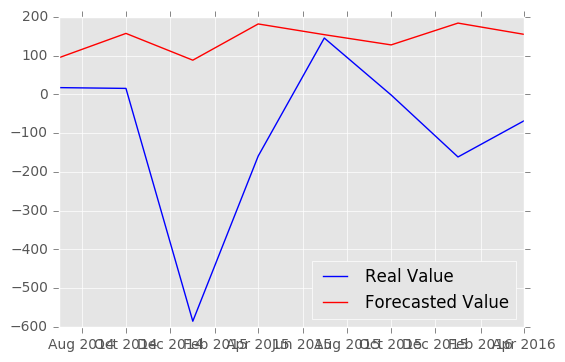

In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 11.994510472580735, 'rmse': 12.609033705111994, 'mse': 158.98773097665031}
{'mae': 7.9834389340837726, 'rmse': 8.6336945642902059, 'mse': 74.540681829454257}
{'mae': 1086.9053583006364, 'rmse': 1250.6679104419516, 'mse': 1564170.2222092375}


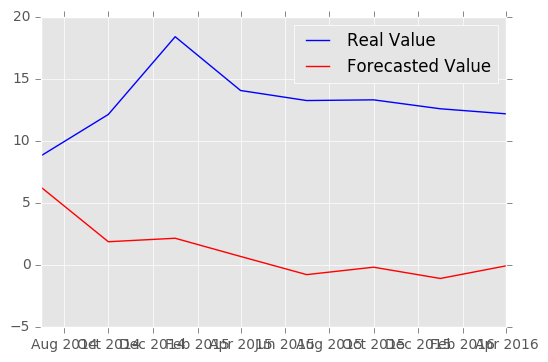

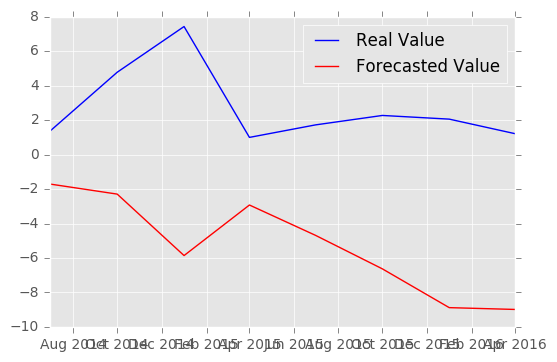

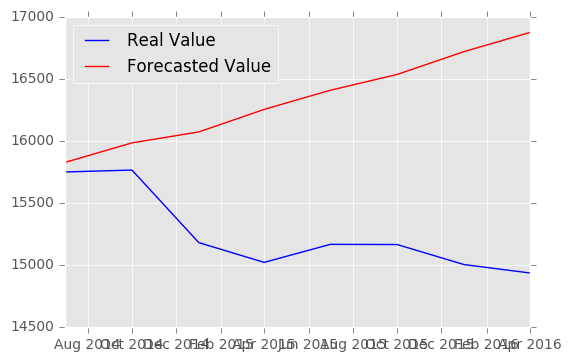

In [70]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [71]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2703
Epoch 2/200
0s - loss: 1.1271
Epoch 3/200
0s - loss: 1.0519
Epoch 4/200
0s - loss: 1.0211
Epoch 5/200
0s - loss: 1.0184
Epoch 6/200
0s - loss: 1.0117
Epoch 7/200
0s - loss: 0.9642
Epoch 8/200
0s - loss: 1.0025
Epoch 9/200
0s - loss: 1.0234
Epoch 10/200
0s - loss: 0.9893
Epoch 11/200
0s - loss: 0.9689
Epoch 12/200
0s - loss: 0.9841
Epoch 13/200
0s - loss: 1.0183
Epoch 14/200
0s - loss: 1.0006
Epoch 15/200
0s - loss: 0.9847
Epoch 16/200
0s - loss: 0.9650
Epoch 17/200
0s - loss: 0.9976
Epoch 18/200
0s - loss: 0.9738
Epoch 19/200
0s - loss: 0.9716
Epoch 20/200
0s - loss: 0.9998
Epoch 21/200
0s - loss: 0.9639
Epoch 22/200
0s - loss: 0.9641
Epoch 23/200
0s - loss: 0.9952
Epoch 24/200
0s - loss: 0.9637
Epoch 25/200
0s - loss: 0.9686
Epoch 26/200
0s - loss: 0.9740
Epoch 27/200
0s - loss: 0.9784
Epoch 28/200
0s - loss: 0.9616
Epoch 29/200
0s - loss: 0.9732
Epoch 30/200
0s - loss: 0.9693
Epoch 31/200
0s - loss: 0.9738
Epoch 32/200
0s - loss: 0.9427
Epoch 33/200
0s -

{'mae': 2.2184265032395034, 'rmse': 3.1439477500656214, 'mse': 9.8844074551426822}
{'mae': 1.7431881069255051, 'rmse': 2.3923367179479209, 'mse': 5.7232749720418292}
{'mae': 250.09990497284187, 'rmse': 326.36238436381507, 'mse': 106512.40592763458}


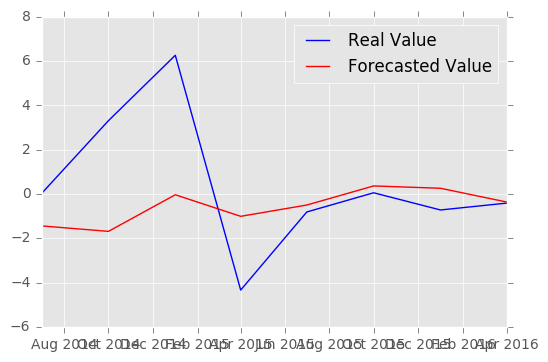

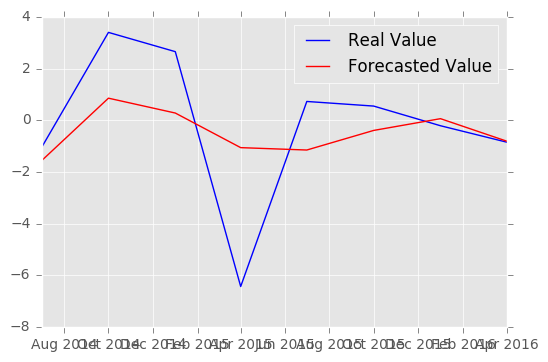

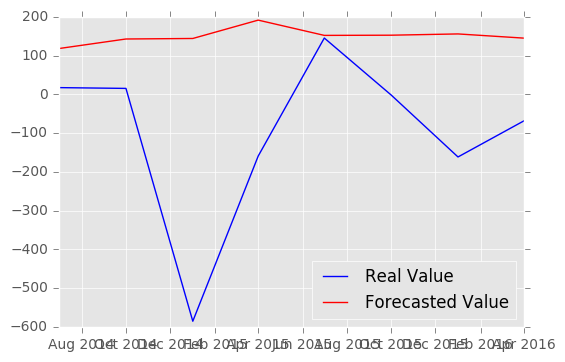

In [72]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 7.9599057845062102, 'rmse': 8.5049405116292842, 'mse': 72.334013106352984}
{'mae': 2.3829880177860918, 'rmse': 2.8423011529678255, 'mse': 8.0786758441622304}
{'mae': 1146.3235323532315, 'rmse': 1312.6604027496949, 'mse': 1723077.3329469911}


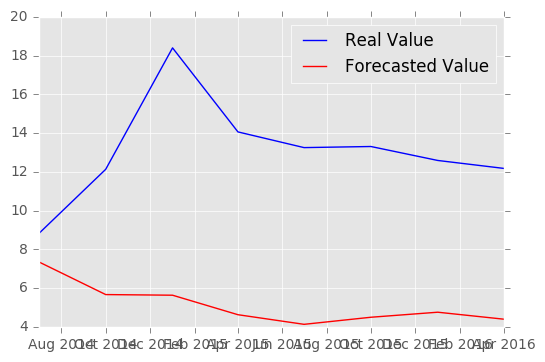

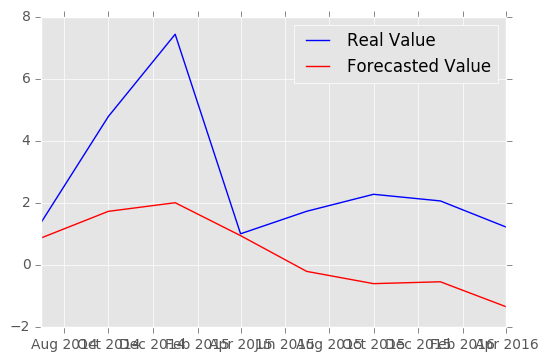

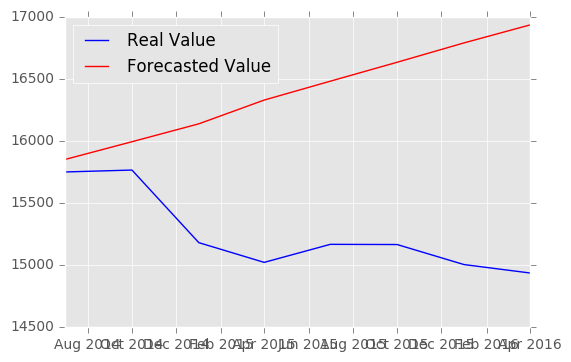

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid_full

In [74]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.4177
Epoch 2/500
0s - loss: 1.1210
Epoch 3/500
0s - loss: 0.9793
Epoch 4/500
0s - loss: 0.9014
Epoch 5/500
0s - loss: 0.8462
Epoch 6/500
0s - loss: 0.8078
Epoch 7/500
0s - loss: 0.7760
Epoch 8/500
0s - loss: 0.7554
Epoch 9/500
0s - loss: 0.7222
Epoch 10/500
0s - loss: 0.6989
Epoch 11/500
0s - loss: 0.6771
Epoch 12/500
0s - loss: 0.6589
Epoch 13/500
0s - loss: 0.6379
Epoch 14/500
0s - loss: 0.6209
Epoch 15/500
0s - loss: 0.6038
Epoch 16/500
0s - loss: 0.5886
Epoch 17/500
0s - loss: 0.5733
Epoch 18/500
0s - loss: 0.5564
Epoch 19/500
0s - loss: 0.5418
Epoch 20/500
0s - loss: 0.5291
Epoch 21/500
0s - loss: 0.5165
Epoch 22/500
0s - loss: 0.4999
Epoch 23/500
0s - loss: 0.4878
Epoch 24/500
0s - loss: 0.4759
Epoch 25/500
0s - loss: 0.4638
Epoch 26/500
0s - loss: 0.4509
Epoch 27/500
0s - loss: 0.4398
Epoch 28/500
0s - loss: 0.4296
Epoch 29/500
0s - loss: 0.4181
Epoch 30/500
0s - loss: 0.4097
Epoch 31/500
0s - loss: 0.3994
Epoch 32/500
0s - loss: 0.3911
Epoch 33/500
0s -

{'mae': 25.238466387254661, 'rmse': 25.518900717935388, 'mse': 651.21429385184319}
{'mae': 2.9552392753067629, 'rmse': 3.2546474123527389, 'mse': 10.592729778734379}
{'mae': 1170.6454879784551, 'rmse': 1345.3487631714513, 'mse': 1809963.294566954}


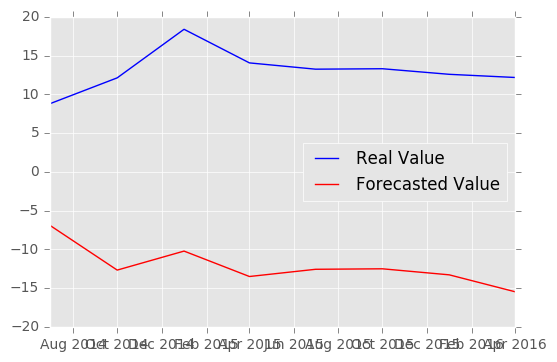

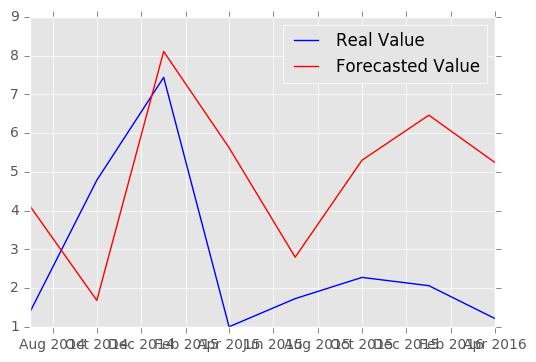

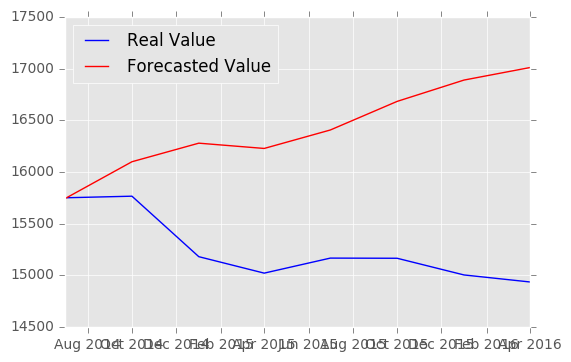

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.0962
Epoch 2/500
0s - loss: 0.9936
Epoch 3/500
0s - loss: 0.9431
Epoch 4/500
0s - loss: 0.9101
Epoch 5/500
0s - loss: 0.8810
Epoch 6/500
0s - loss: 0.8538
Epoch 7/500
0s - loss: 0.8259
Epoch 8/500
0s - loss: 0.7968
Epoch 9/500
0s - loss: 0.7711
Epoch 10/500
0s - loss: 0.7418
Epoch 11/500
0s - loss: 0.7143
Epoch 12/500
0s - loss: 0.6860
Epoch 13/500
0s - loss: 0.6624
Epoch 14/500
0s - loss: 0.6356
Epoch 15/500
0s - loss: 0.6098
Epoch 16/500
0s - loss: 0.5895
Epoch 17/500
0s - loss: 0.5663
Epoch 18/500
0s - loss: 0.5471
Epoch 19/500
0s - loss: 0.5272
Epoch 20/500
0s - loss: 0.5089
Epoch 21/500
0s - loss: 0.4903
Epoch 22/500
0s - loss: 0.4763
Epoch 23/500
0s - loss: 0.4618
Epoch 24/500
0s - loss: 0.4490
Epoch 25/500
0s - loss: 0.4349
Epoch 26/500
0s - loss: 0.4245
Epoch 27/500
0s - loss: 0.4121
Epoch 28/500
0s - loss: 0.4028
Epoch 29/500
0s - loss: 0.3930
Epoch 30/500
0s - loss: 0.3839
Epoch 31/500
0s - loss: 0.3780
Epoch 32/500
0s - loss: 0.3684
Epoch 33/500
0s -

{'mae': 26.089600155478418, 'rmse': 26.551445480347578, 'mse': 704.9792570958698}
{'mae': 4.0086723565770912, 'rmse': 5.6346016144471678, 'mse': 31.74873535353063}
{'mae': 1297.2410771937032, 'rmse': 1397.2335060256448, 'mse': 1952261.4703607159}


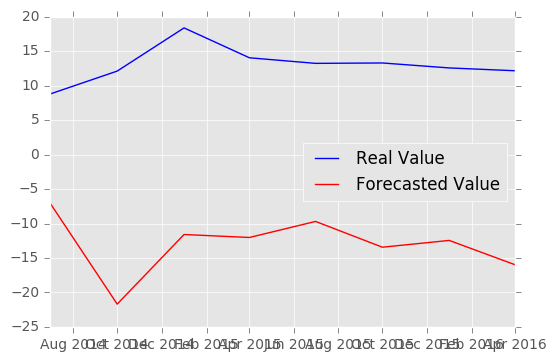

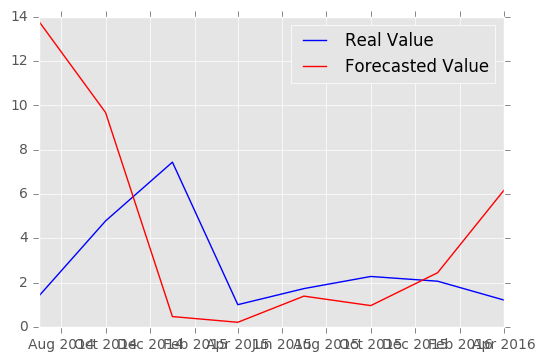

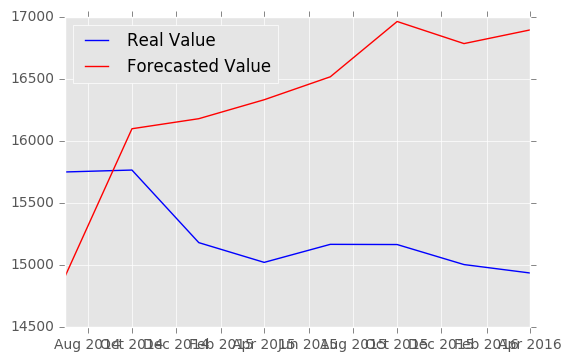

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [79]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1639
Epoch 2/500
0s - loss: 1.0585
Epoch 3/500
0s - loss: 1.0169
Epoch 4/500
0s - loss: 0.9712
Epoch 5/500
0s - loss: 1.0095
Epoch 6/500
0s - loss: 0.9971
Epoch 7/500
0s - loss: 0.9974
Epoch 8/500
0s - loss: 0.9751
Epoch 9/500
0s - loss: 0.9737
Epoch 10/500
0s - loss: 0.9682
Epoch 11/500
0s - loss: 0.9659
Epoch 12/500
0s - loss: 0.9907
Epoch 13/500
0s - loss: 0.9648
Epoch 14/500
0s - loss: 0.9506
Epoch 15/500
0s - loss: 0.9696
Epoch 16/500
0s - loss: 0.9594
Epoch 17/500
0s - loss: 0.9624
Epoch 18/500
0s - loss: 0.9270
Epoch 19/500
0s - loss: 0.9173
Epoch 20/500
0s - loss: 0.9256
Epoch 21/500
0s - loss: 0.9341
Epoch 22/500
0s - loss: 0.9237
Epoch 23/500
0s - loss: 0.9618
Epoch 24/500
0s - loss: 0.9150
Epoch 25/500
0s - loss: 0.9311
Epoch 26/500
0s - loss: 0.9278
Epoch 27/500
0s - loss: 0.9363
Epoch 28/500
0s - loss: 0.8754
Epoch 29/500
0s - loss: 0.8733
Epoch 30/500
0s - loss: 0.8994
Epoch 31/500
0s - loss: 0.9578
Epoch 32/500
0s - loss: 0.9265
Epoch 33/500
0s -

{'mae': 24.170086860528922, 'rmse': 24.578713686544248, 'mse': 604.11316648511752}
{'mae': 5.2086227240784844, 'rmse': 5.7807999338309095, 'mse': 33.417647874979444}
{'mae': 1011.1767166744489, 'rmse': 1166.9853432361058, 'mse': 1361854.7913278914}


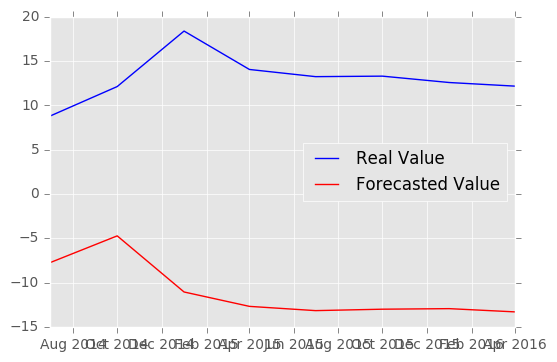

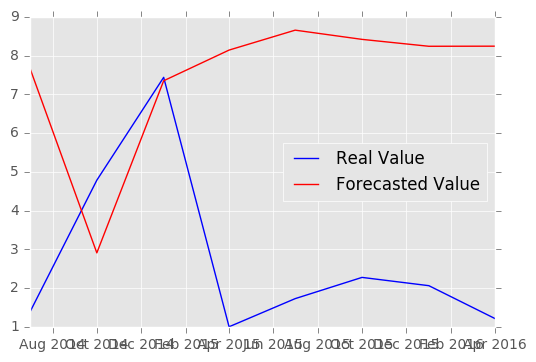

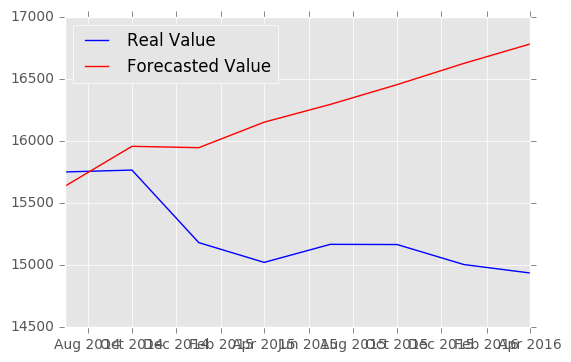

In [80]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])